In [1]:
import os

import jax
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from environments.harmonic_oscillator import HarmonicOscillator
from evaluators.sho_evaluator import *
from utils import get_data, get_strategy, validate

device = jax.devices()[0].platform
print(f"Using device: {device}")

plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "text.usetex": True,
    "font.family": "times",
})

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

These device(s) are detected:  [CpuDevice(id=0)]
Using device: cpu


In [2]:
args = {
    "param_setting": "constant",
    "n_obs": 2,
    "process_noise": 0.05,
    "obs_noise": 0.3
}

In [3]:
def test_model_single_seed(args, model_path, learn_condition, feedback_fn, sign_estimation, seed, n_jumps):
    env = HarmonicOscillator(args["process_noise"], args["obs_noise"], args["n_obs"])
    test_data = get_data(jr.PRNGKey(seed), env, batch_size=4, dt=0.2, T=40.0, param_setting=args["param_setting"], n_jumps=n_jumps)
    operator_list = [
        ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
        ("*", lambda x, y: jnp.multiply(x, y), 2, 0.5),
        ("-", lambda x, y: jnp.subtract(x, y), 2, 0.3),
        ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
    ]
    strategy, fitness_function = get_strategy(env, learn_condition, feedback_fn, sign_estimation, operator_list, dt0=0.05, device=device)
    best_fitness, best_model = validate(np.load(f"{model_path}/best_solutions.npy"), strategy, test_data)
    return test_data, strategy, fitness_function, best_model, best_fitness

def test_model(args, model_path, learn_condition, feedback_fn, sign_estimation, n_seeds=10, n_jumps=0):
    best_fitnesses = []
    for seed in range(n_seeds):
        _, _, _, _, best_fitness = test_model_single_seed(args, model_path, learn_condition, feedback_fn, sign_estimation, 
                                                        seed=seed, n_jumps=n_jumps)
        best_fitnesses.append(-best_fitness)
    best_fitnesses = jnp.array(best_fitnesses)
    return best_fitnesses

def plot_trajectories(model, strategy, fitness_fn, learn_condition, test_data_static, test_data_dynamic, 
                    title=None, ylim_bottom=None, ylim_top=None):
    xs_static, ys_static, us_static, activities_static, fitness_static, fbs_static = jax.vmap(
        fitness_fn.evaluate_trajectory,
        in_axes=[None, 0, None, 0, 0, 0, None]
    )(model, *test_data_static, strategy.tree_evaluator)

    xs_dyn, ys_dyn, us_dyn, activities_dyn, fitness_dyn, fbs_dyn = jax.vmap(
        fitness_fn.evaluate_trajectory,
        in_axes=[None, 0, None, 0, 0, 0, None]
    )(model, *test_data_dynamic, strategy.tree_evaluator)

    ts_static = test_data_static[1]
    ts_dyn = test_data_dynamic[1]
    targets_static = test_data_static[2]
    targets_dyn = test_data_dynamic[2]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    titles = ["Static target", "Dynamic target"]

    i = 0
    # Plot for static target
    axs[0].plot(ts_static, xs_static[i, :, 0], label="$x_0$", color="#1f77b4", linewidth=1.8)
    axs[0].plot(ts_static, xs_static[i, :, 1], label="$x_1$", color="#ff7f0e", linewidth=1.8)
    axs[0].plot(ts_static, ys_static[i, :, 0], alpha=0.2, color="#1f77b4")
    axs[0].plot(ts_static, ys_static[i, :, 1], alpha=0.2, color="#ff7f0e")
    axs[0].plot(ts_static, us_static[i, :], label="$u$", color="#2ca02c", linewidth=1.8)
    if learn_condition == 2:
        axs[0].plot(ts_static, fbs_static[i, :], label="$e$", color="#d62728", linewidth=1.8)
    axs[0].plot(ts_static, targets_static[i, :, 0], '--k', lw=2)

    axs[0].set_title(titles[0], fontsize=16)
    axs[0].set_xlabel("Time", fontsize=14)
    axs[0].set_ylabel("Value", fontsize=14)
    axs[0].spines[['right', 'top']].set_visible(False)
    if ylim_bottom is not None or ylim_top is not None:
        axs[0].set_ylim(bottom=ylim_bottom, top=ylim_top)
    axs[0].tick_params(axis='x', labelsize=12)
    axs[0].tick_params(axis='y', labelsize=12)

    # Plot for dynamic target
    axs[1].plot(ts_dyn, xs_dyn[i, :, 0], label="$x_0$", color="#1f77b4", linewidth=1.8)
    axs[1].plot(ts_dyn, xs_dyn[i, :, 1], label="$x_1$", color="#ff7f0e", linewidth=1.8)
    axs[1].plot(ts_dyn, ys_dyn[i, :, 0], alpha=0.2, color="#1f77b4")
    axs[1].plot(ts_dyn, ys_dyn[i, :, 1], alpha=0.2, color="#ff7f0e")
    axs[1].plot(ts_dyn, us_dyn[i, :], label="$u$", color="#2ca02c", linewidth=1.8)
    if learn_condition == 2:
        axs[1].plot(ts_dyn, fbs_dyn[i, :], label="$e$", color="#d62728", linewidth=1.8)
    axs[1].plot(ts_dyn, targets_dyn[i, :, 0], '--k', lw=2)

    axs[1].set_title(titles[1], fontsize=16)
    axs[1].set_xlabel("Time", fontsize=14)
    axs[1].spines[['right', 'top']].set_visible(False)
    axs[1].tick_params(axis='x', labelsize=12)
    axs[1].tick_params(axis='y', labelsize=12)

    handles = [
        plt.Line2D([], [], color="#1f77b4", lw=1.8, label="$x_0$"),
        plt.Line2D([], [], color="#ff7f0e", lw=1.8, label="$x_1$"),
        plt.Line2D([], [], color="#2ca02c", lw=1.8, label="$u$"),
    ]
    if learn_condition == 2:
        handles.append(plt.Line2D([], [], color="#d62728", lw=1.8, label="$e$"))
    handles.append(plt.Line2D([], [], color="k", lw=2, ls="--", label="target"))
    fig.legend(handles=handles, loc="lower center", ncol=5, frameon=False, fontsize=14)
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()

## GP-ODE

### Condition (i): Non-stationary task objective

In [4]:
learn_condition = 1
feedback_fn = None
sign_estimation = False
seed = 0

test_data_static, strategy, fitness_fn, model, _ = test_model_single_seed(args,
                                    model_path="results/harmonic_oscillator/full_obs/direct_target",
                                    learn_condition=learn_condition,
                                    feedback_fn=feedback_fn,
                                    sign_estimation=sign_estimation,
                                    seed=seed,
                                    n_jumps=0)
test_data_dynamic, _, _, _, _ = test_model_single_seed(args,
                                    model_path="results/harmonic_oscillator/full_obs/direct_target",
                                    learn_condition=learn_condition,
                                    feedback_fn=feedback_fn,
                                    sign_estimation=sign_estimation,
                                    seed=seed,
                                    n_jumps=3)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].


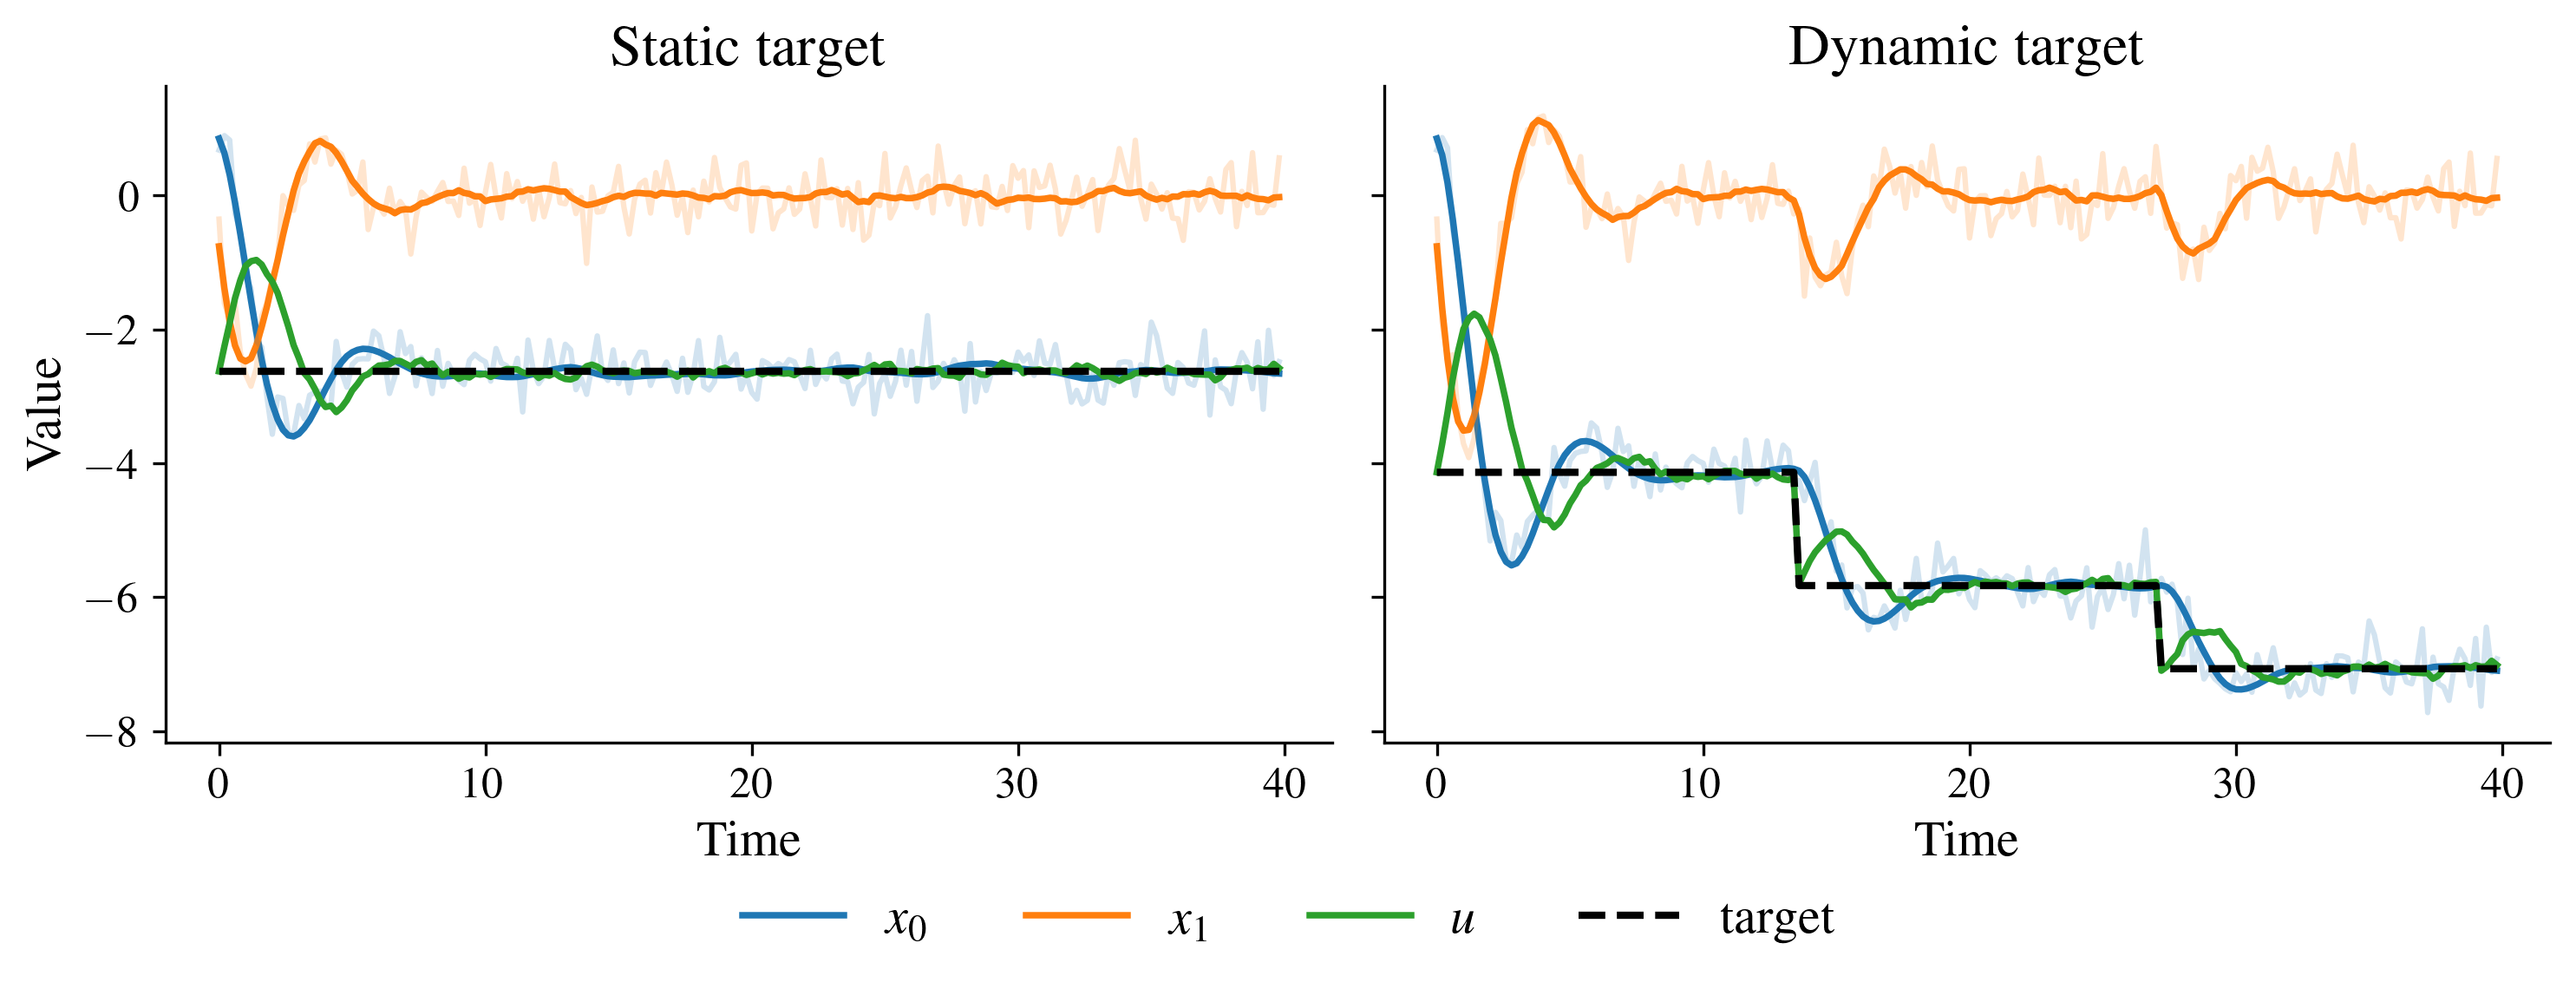

In [5]:
plot_trajectories(model, strategy, fitness_fn, learn_condition, test_data_static, test_data_dynamic)

### Condition (ii): Learning through feedback

In [6]:
def distance_feedback(x, target):
    err = x[0] - target
    return 0.5 * err**2

def direction_feedback(x, target):
    return target - x[0]

learn_condition = 2
seed = 2709

In [7]:
fitness_trace1 = np.load(f"results/harmonic_oscillator/full_obs/direction_feedback/best_fitnesses.npy")
fitness_trace2 = np.load(f"results/harmonic_oscillator/full_obs/distance_feedback/best_fitnesses.npy")
fitness_trace3 = np.load(f"results/harmonic_oscillator/full_obs/tpse_direction_feedback/best_fitnesses.npy")
fitness_trace4 = np.load(f"results/harmonic_oscillator/full_obs/tpse_distance_feedback/best_fitnesses.npy")

test_fitnesses1 = test_model(args, 
                            "results/harmonic_oscillator/full_obs/direction_feedback",
                            learn_condition=learn_condition, 
                            feedback_fn=direction_feedback,
                            sign_estimation=False)
test_fitnesses2 = test_model(args, 
                            "results/harmonic_oscillator/full_obs/distance_feedback", 
                            learn_condition=learn_condition, 
                            feedback_fn=distance_feedback,
                            sign_estimation=False)
test_fitnesses3 = test_model(args, 
                            "results/harmonic_oscillator/full_obs/tpse_direction_feedback", 
                            learn_condition=learn_condition,
                            feedback_fn=direction_feedback,
                            sign_estimation=True)
test_fitnesses4 = test_model(args, 
                            "results/harmonic_oscillator/full_obs/tpse_distance_feedback", 
                            learn_condition=learn_condition,
                            feedback_fn=distance_feedback,
                            sign_estimation=True)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0'

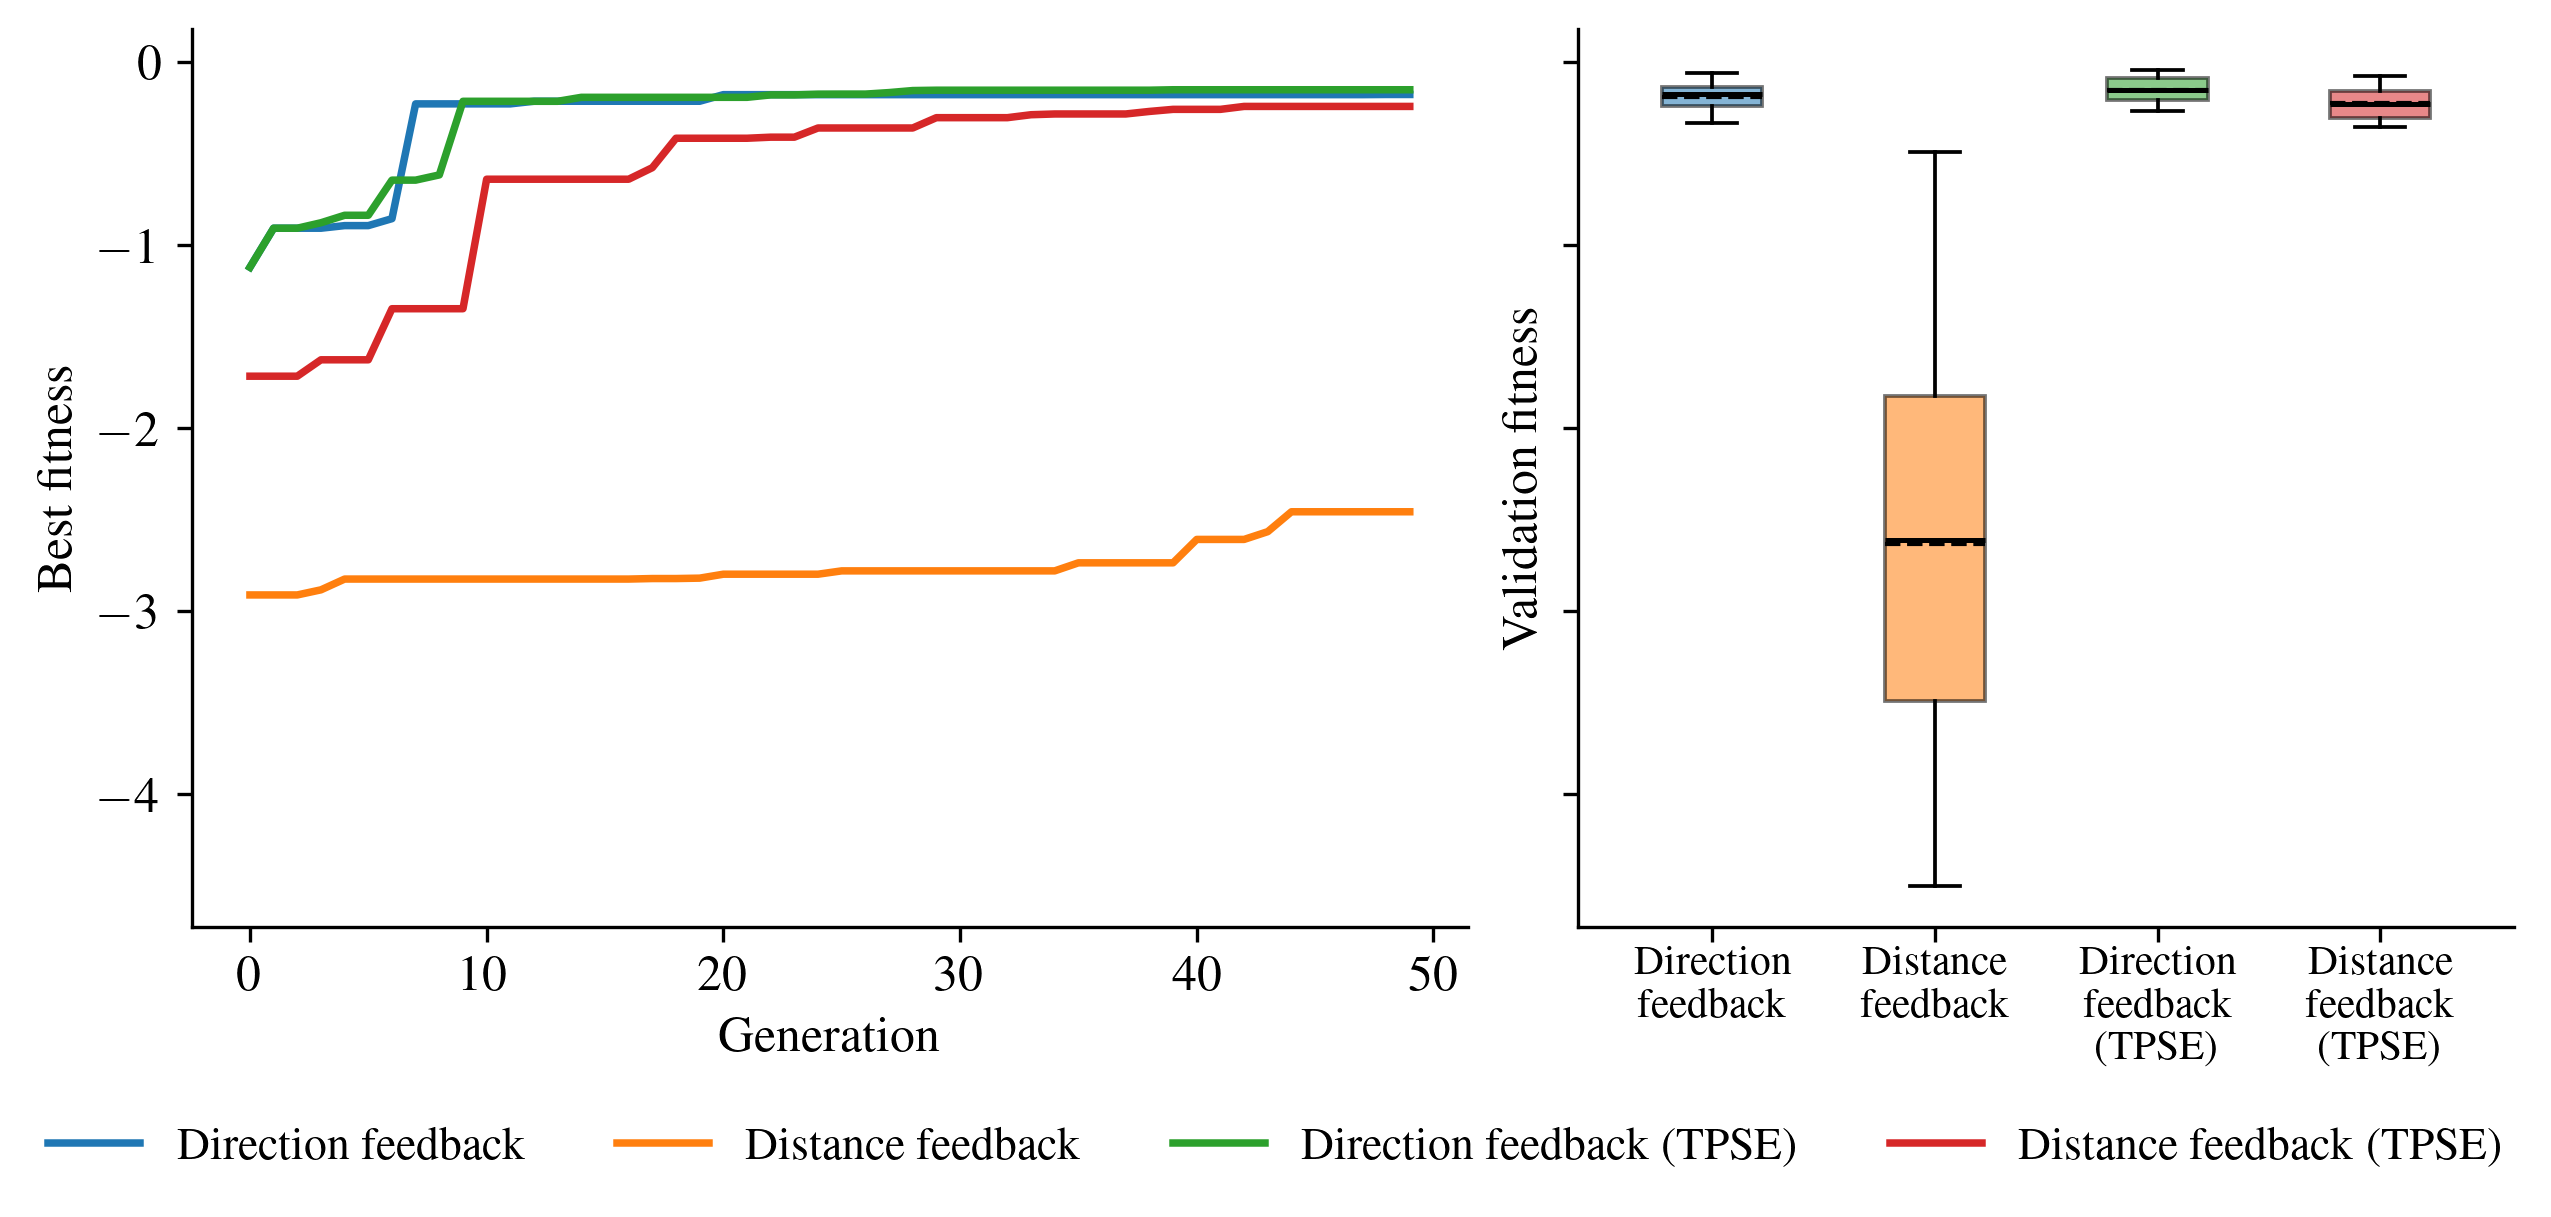

In [8]:
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [3.0, 2.2]}, figsize=(8.6, 4.1), sharey=True)

axs[0].plot(-fitness_trace1, lw=1.8, color="#1f77b4", label="Direction feedback")
axs[0].plot(-fitness_trace2, lw=1.8, color="#ff7f0e", label="Distance feedback")
axs[0].plot(-fitness_trace3, lw=1.8, color="#2ca02c", label="Direction feedback (TPSE)")
axs[0].plot(-fitness_trace4, lw=1.8, color="#d62728", label="Distance feedback (TPSE)")
axs[0].set_xlabel("Generation", fontsize=12)
axs[0].set_ylabel("Best fitness", fontsize=12)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].spines[["right", "top"]].set_visible(False)

groups = [
    np.asarray(test_fitnesses1),
    np.asarray(test_fitnesses2),
    np.asarray(test_fitnesses3),
    np.asarray(test_fitnesses4),
]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

bp = axs[1].boxplot(groups, widths=0.45, patch_artist=True,
                    showmeans=True, meanline=True,
                    boxprops=dict(edgecolor="black", linewidth=0.9),
                    medianprops=dict(color="black", linewidth=1.2),
                    whiskerprops=dict(color="black", linewidth=0.9),
                    capprops=dict(color="black", linewidth=0.9),
                    meanprops=dict(color="black", linewidth=1.0),
                    flierprops=dict(marker="o", markersize=2.6, markerfacecolor="gray", markeredgecolor="none", alpha=0.5))

for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)
    patch.set_alpha(0.55)

axs[1].set_xlim(0.4, 4.6)
axs[1].set_xticks([1, 2, 3, 4])
axs[1].set_xticklabels(["Direction\nfeedback", "Distance\nfeedback",
                        "Direction\nfeedback\n(TPSE)", "Distance\nfeedback\n(TPSE)"],
                        linespacing=1.2,
                        fontsize=12)
axs[1].set_ylabel("Validation fitness", fontsize=12)
axs[1].tick_params(axis='x', labelsize=10, pad=1)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].spines[["right", "top"]].set_visible(False)

handles = [
    plt.Line2D([], [], color="#1f77b4", lw=1.8, label="Direction feedback"),
    plt.Line2D([], [], color="#ff7f0e", lw=1.8, label="Distance feedback"),
    plt.Line2D([], [], color="#2ca02c", lw=1.8, label="Direction feedback (TPSE)"),
    plt.Line2D([], [], color="#d62728", lw=1.8, label="Distance feedback (TPSE)"),
]

fig.legend(handles=handles, loc="lower center", ncol=4, frameon=False, fontsize=11, bbox_to_anchor=(0.5, -0.01))
fig.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.22, wspace=0.10)
plt.show()

In [9]:
test_data_static, strategy1, fitness_fn1, model1, _ = test_model_single_seed(args,
                                                                        model_path="results/harmonic_oscillator/full_obs/direction_feedback",
                                                                        learn_condition=learn_condition,
                                                                        feedback_fn=direction_feedback,
                                                                        sign_estimation=False,
                                                                        seed=seed,
                                                                        n_jumps=0)
test_data_dynamic, strategy2, fitness_fn2, model2, _ = test_model_single_seed(args,
                                                                        model_path="results/harmonic_oscillator/full_obs/distance_feedback",
                                                                        learn_condition=learn_condition,
                                                                        feedback_fn=distance_feedback,
                                                                        sign_estimation=False,
                                                                        seed=seed,
                                                                        n_jumps=3)
_, strategy3, fitness_fn3, model3, _ = test_model_single_seed(args,
                                                            model_path="results/harmonic_oscillator/full_obs/tpse_direction_feedback",
                                                            learn_condition=learn_condition,
                                                            feedback_fn=direction_feedback,
                                                            sign_estimation=True,
                                                            seed=seed,
                                                            n_jumps=0)
_, strategy4, fitness_fn4, model4, _ = test_model_single_seed(args,
                                                            model_path="results/harmonic_oscillator/full_obs/tpse_distance_feedback",
                                                            learn_condition=learn_condition,
                                                            feedback_fn=distance_feedback,
                                                            sign_estimation=True,
                                                            seed=seed,
                                                            n_jumps=0)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'e'].


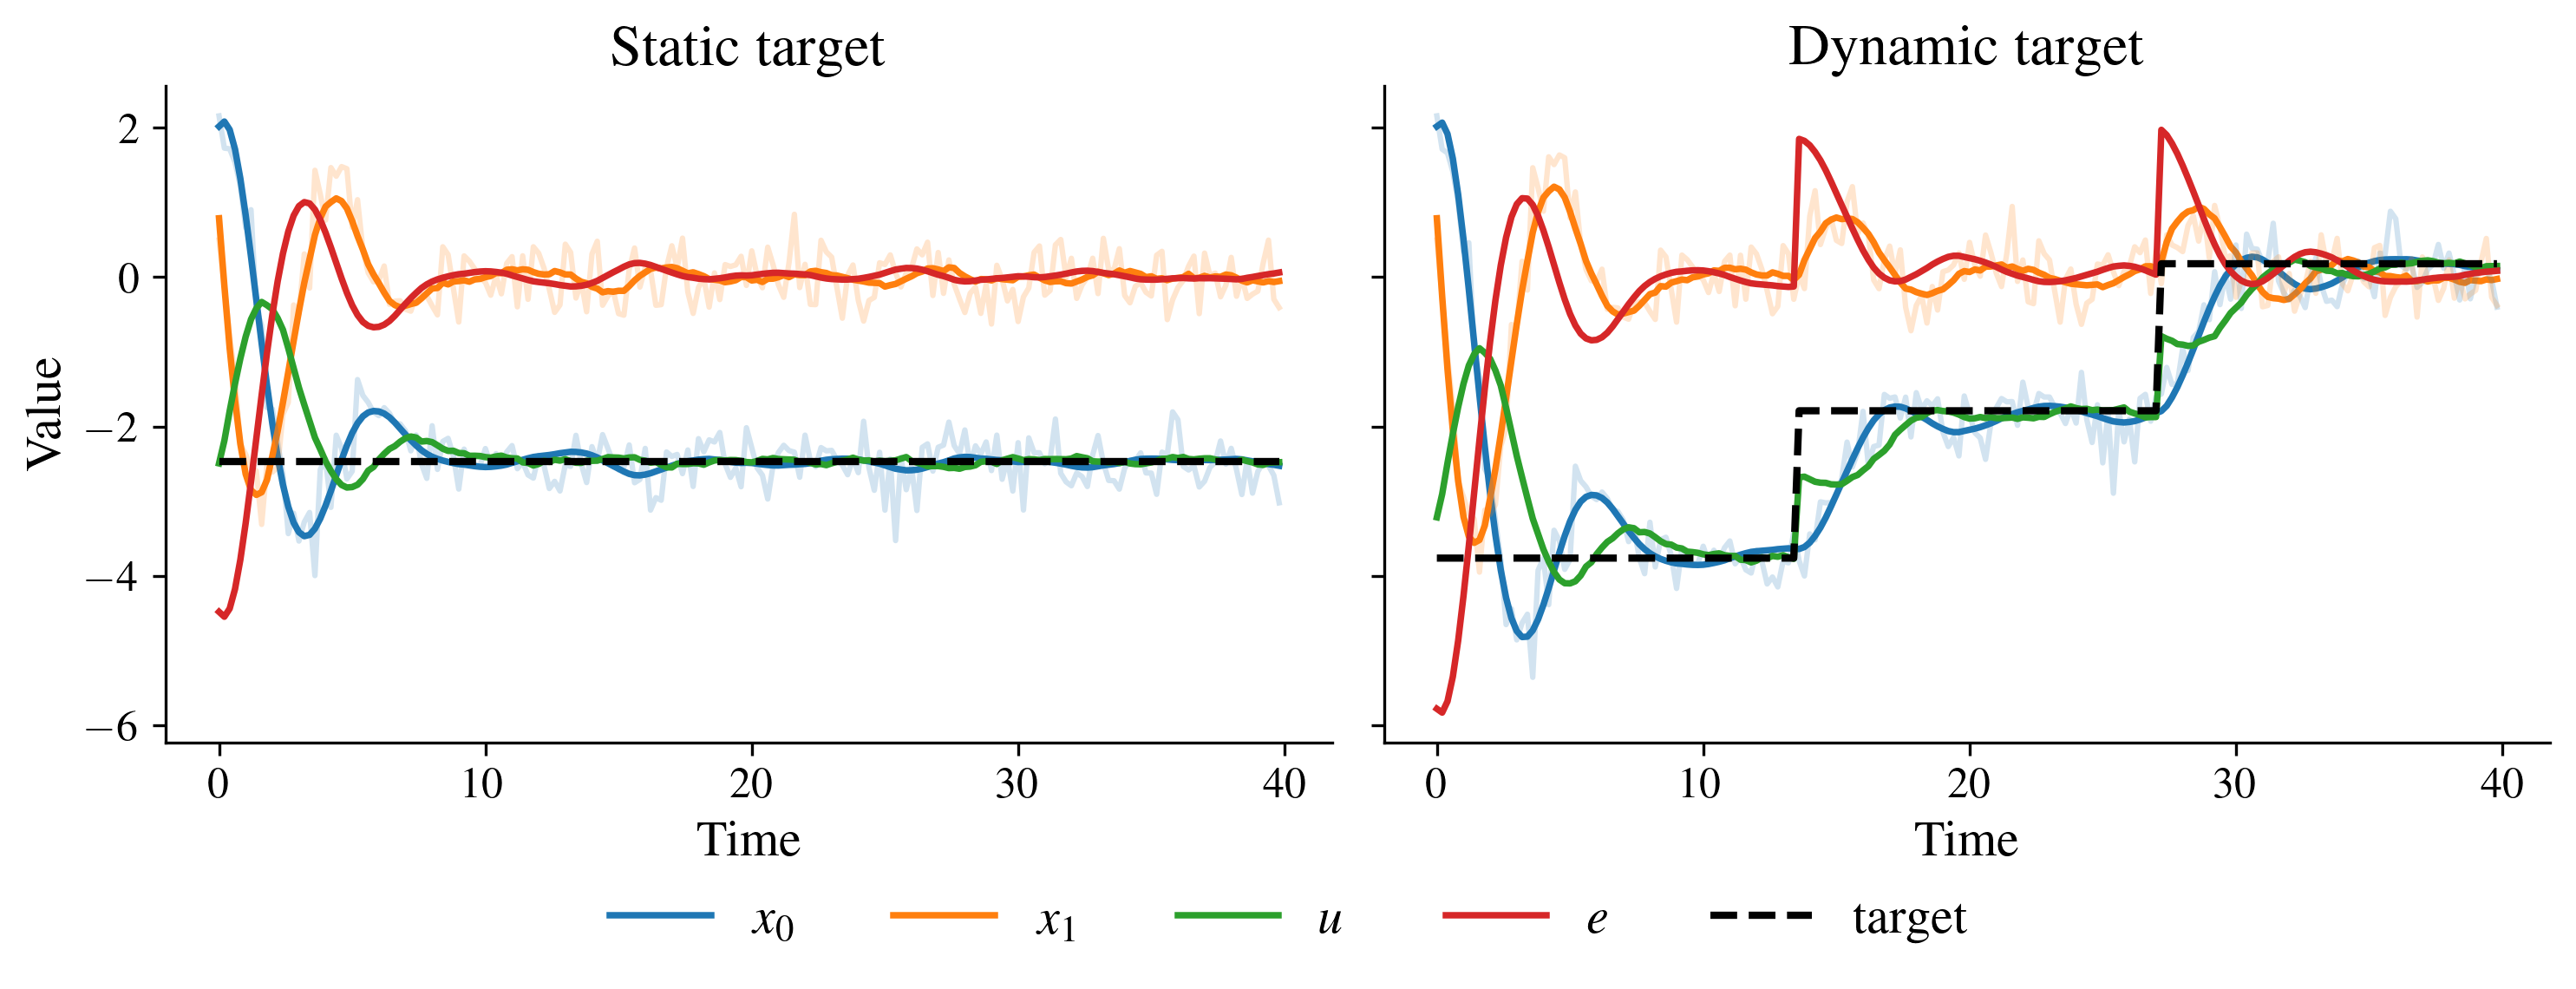

In [10]:
plot_trajectories(model1, strategy1, fitness_fn1, learn_condition, test_data_static, test_data_dynamic)

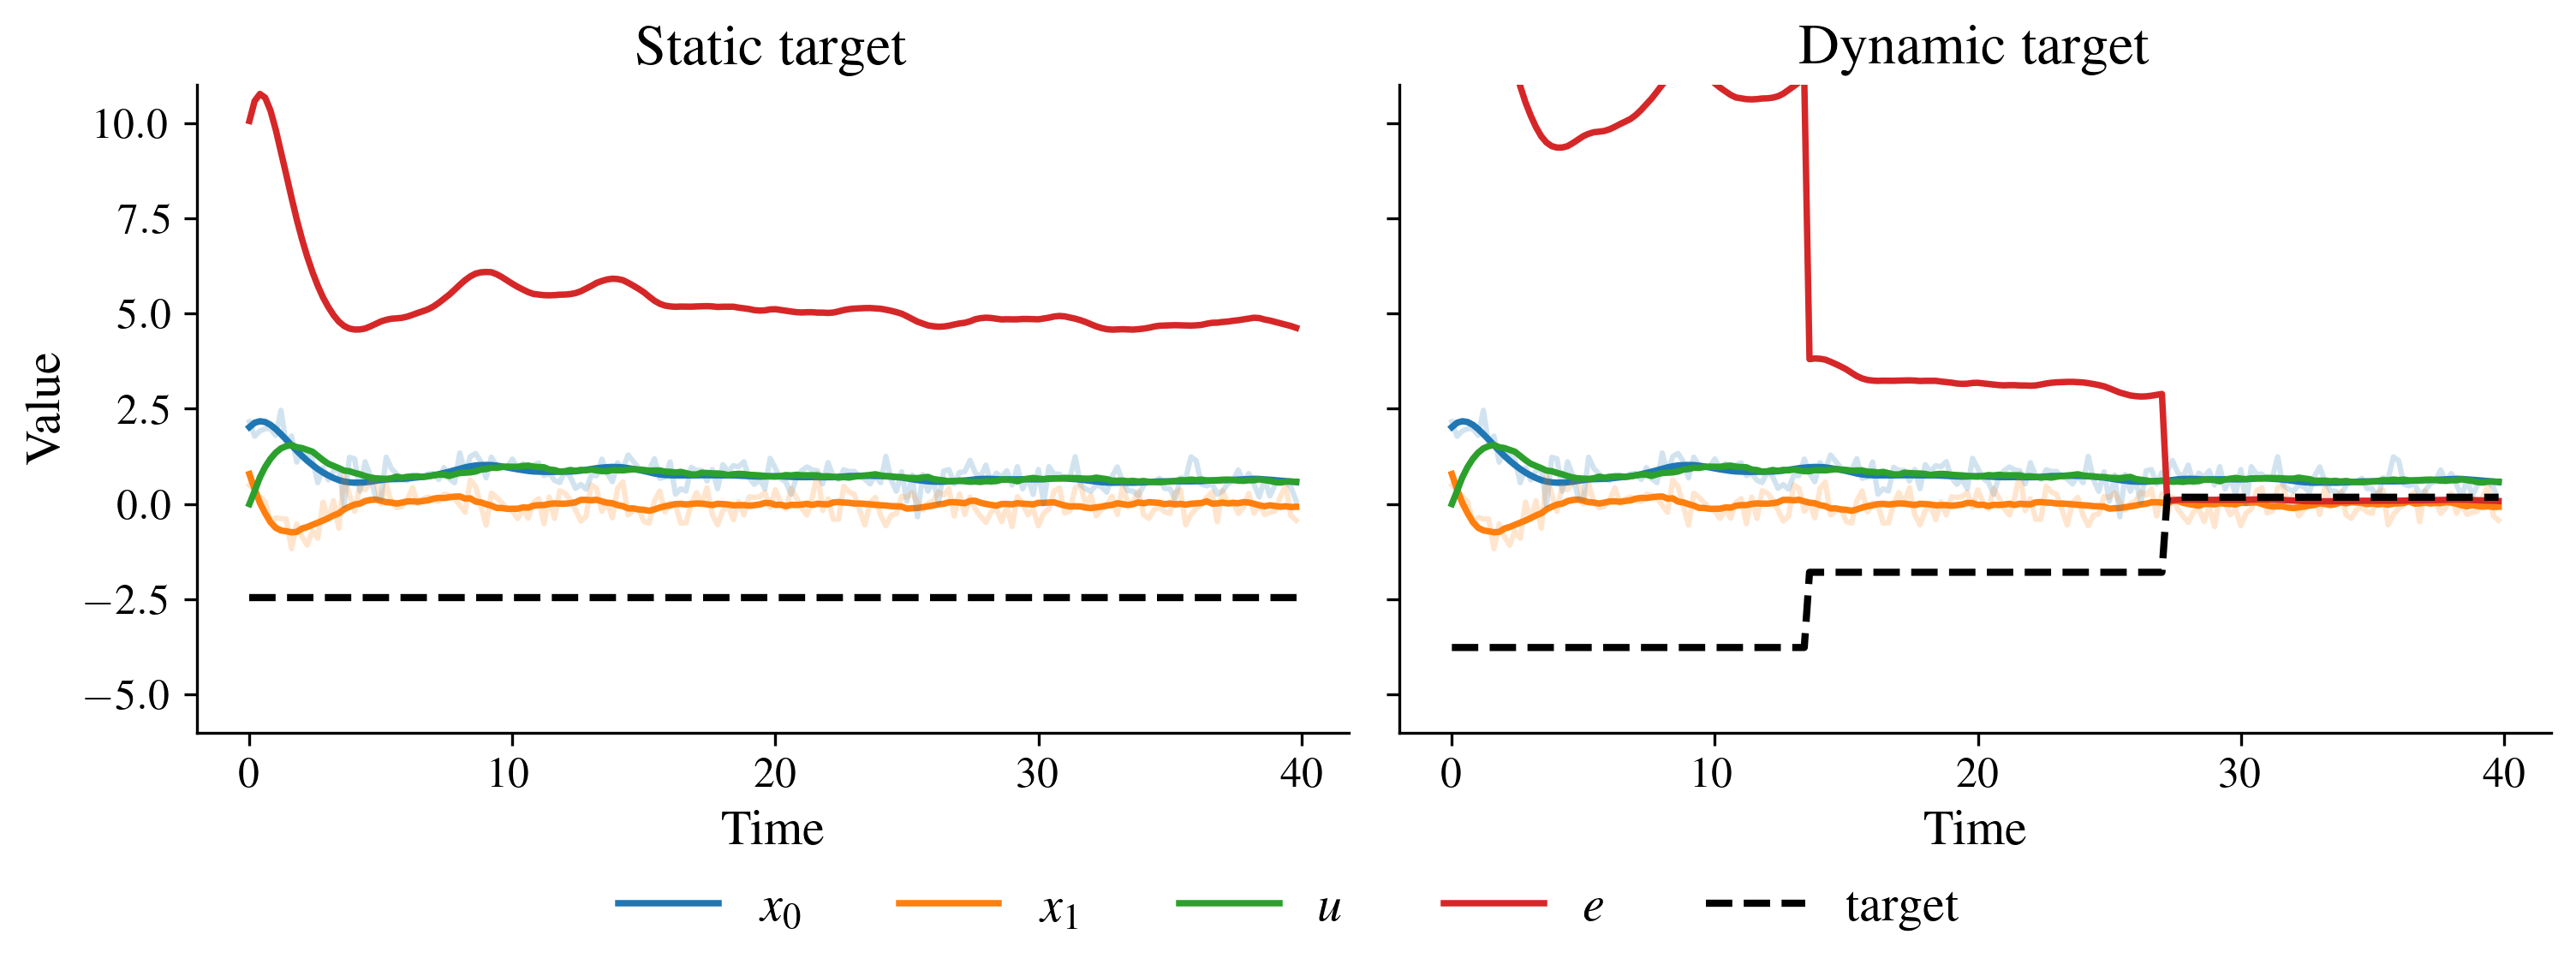

In [11]:
plot_trajectories(model2, strategy2, fitness_fn2, learn_condition, test_data_static, test_data_dynamic, ylim_bottom=-6, ylim_top=11)

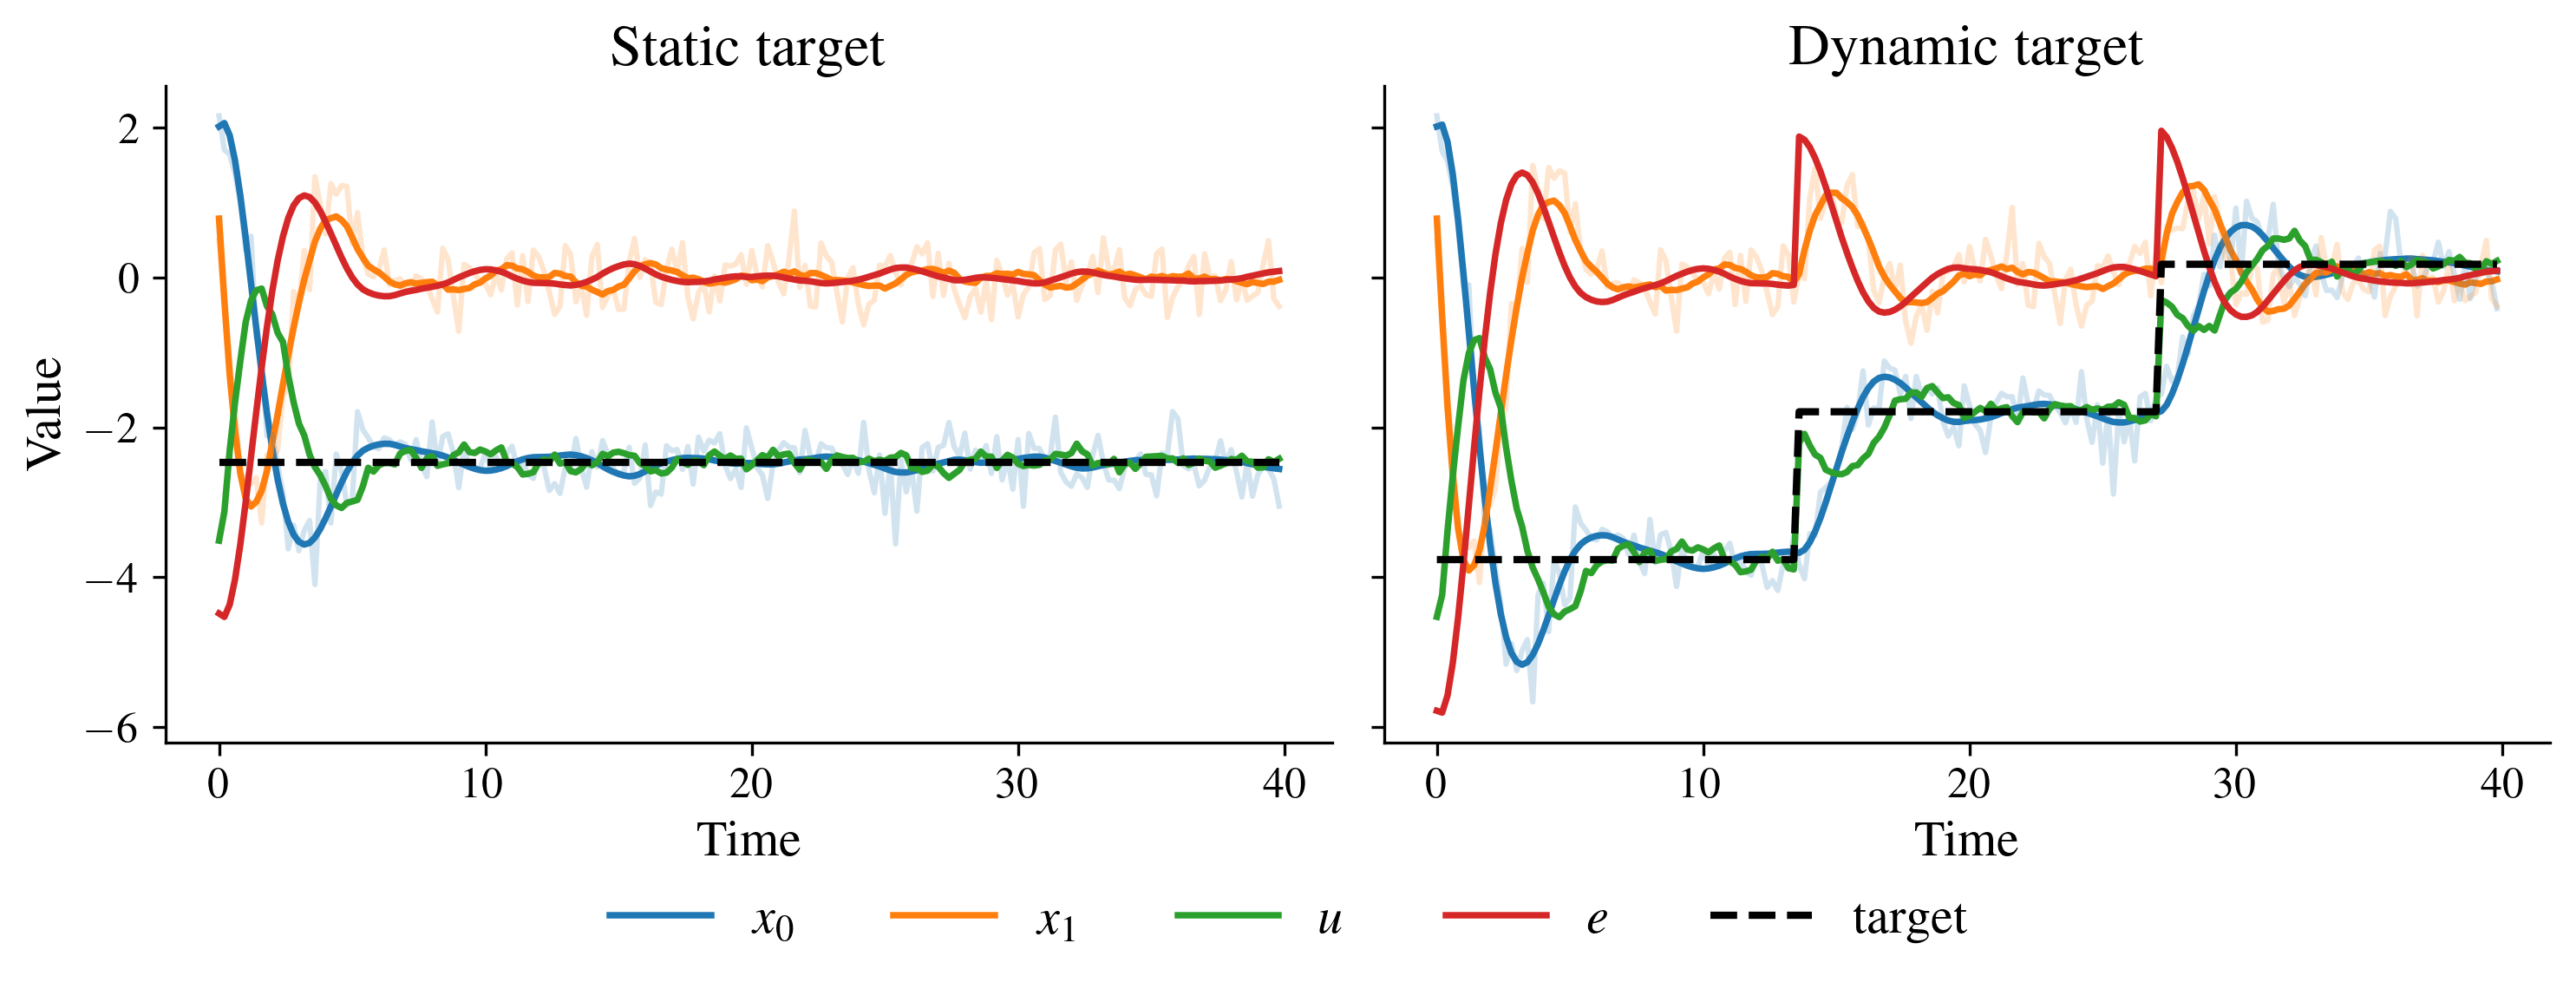

In [12]:
plot_trajectories(model3, strategy3, fitness_fn3, learn_condition, test_data_static, test_data_dynamic)

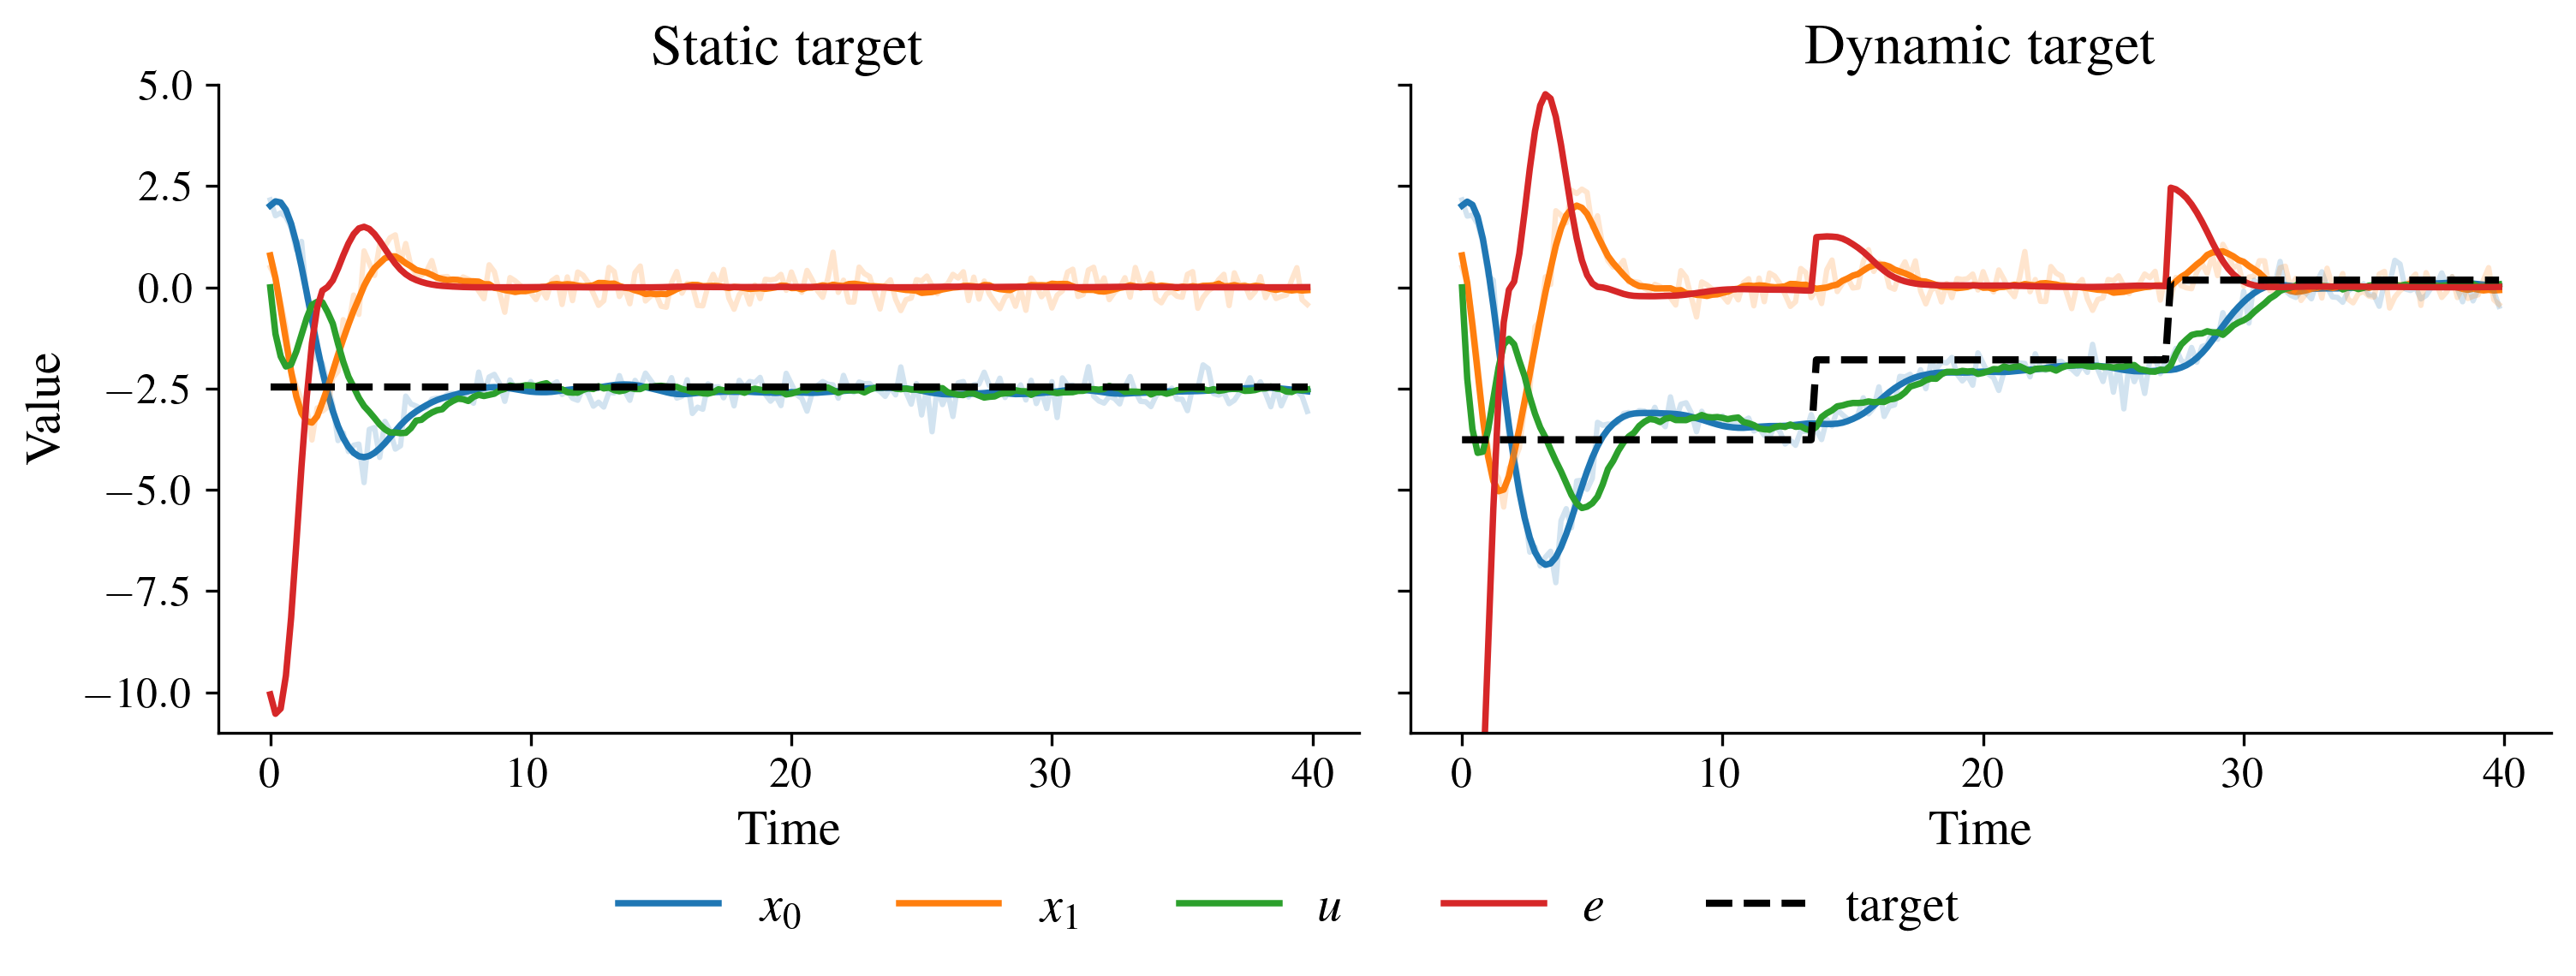

In [13]:
plot_trajectories(model4, strategy4, fitness_fn4, learn_condition, test_data_static, test_data_dynamic, ylim_bottom=-11, ylim_top=5)

### Condition (iii): Learning from noisy observations 

In [14]:
learn_condition = 3
feedback_fn = None
sign_estimation = False
seed = 2709

In [15]:
test_data_static, strategy, fitness_fn, model, _ = test_model_single_seed(args,
                                                                            model_path="results/harmonic_oscillator/full_obs/noisy_obs",
                                                                            learn_condition=learn_condition,
                                                                            feedback_fn=feedback_fn,
                                                                            sign_estimation=sign_estimation,
                                                                            seed=seed,
                                                                            n_jumps=0)
test_data_dynamic, _, _, _, _ = test_model_single_seed(args,
                                                    model_path="results/harmonic_oscillator/full_obs/noisy_obs",
                                                    learn_condition=learn_condition,
                                                    feedback_fn=feedback_fn,
                                                    sign_estimation=sign_estimation,
                                                    seed=seed,
                                                    n_jumps=3)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0'].
Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0'].


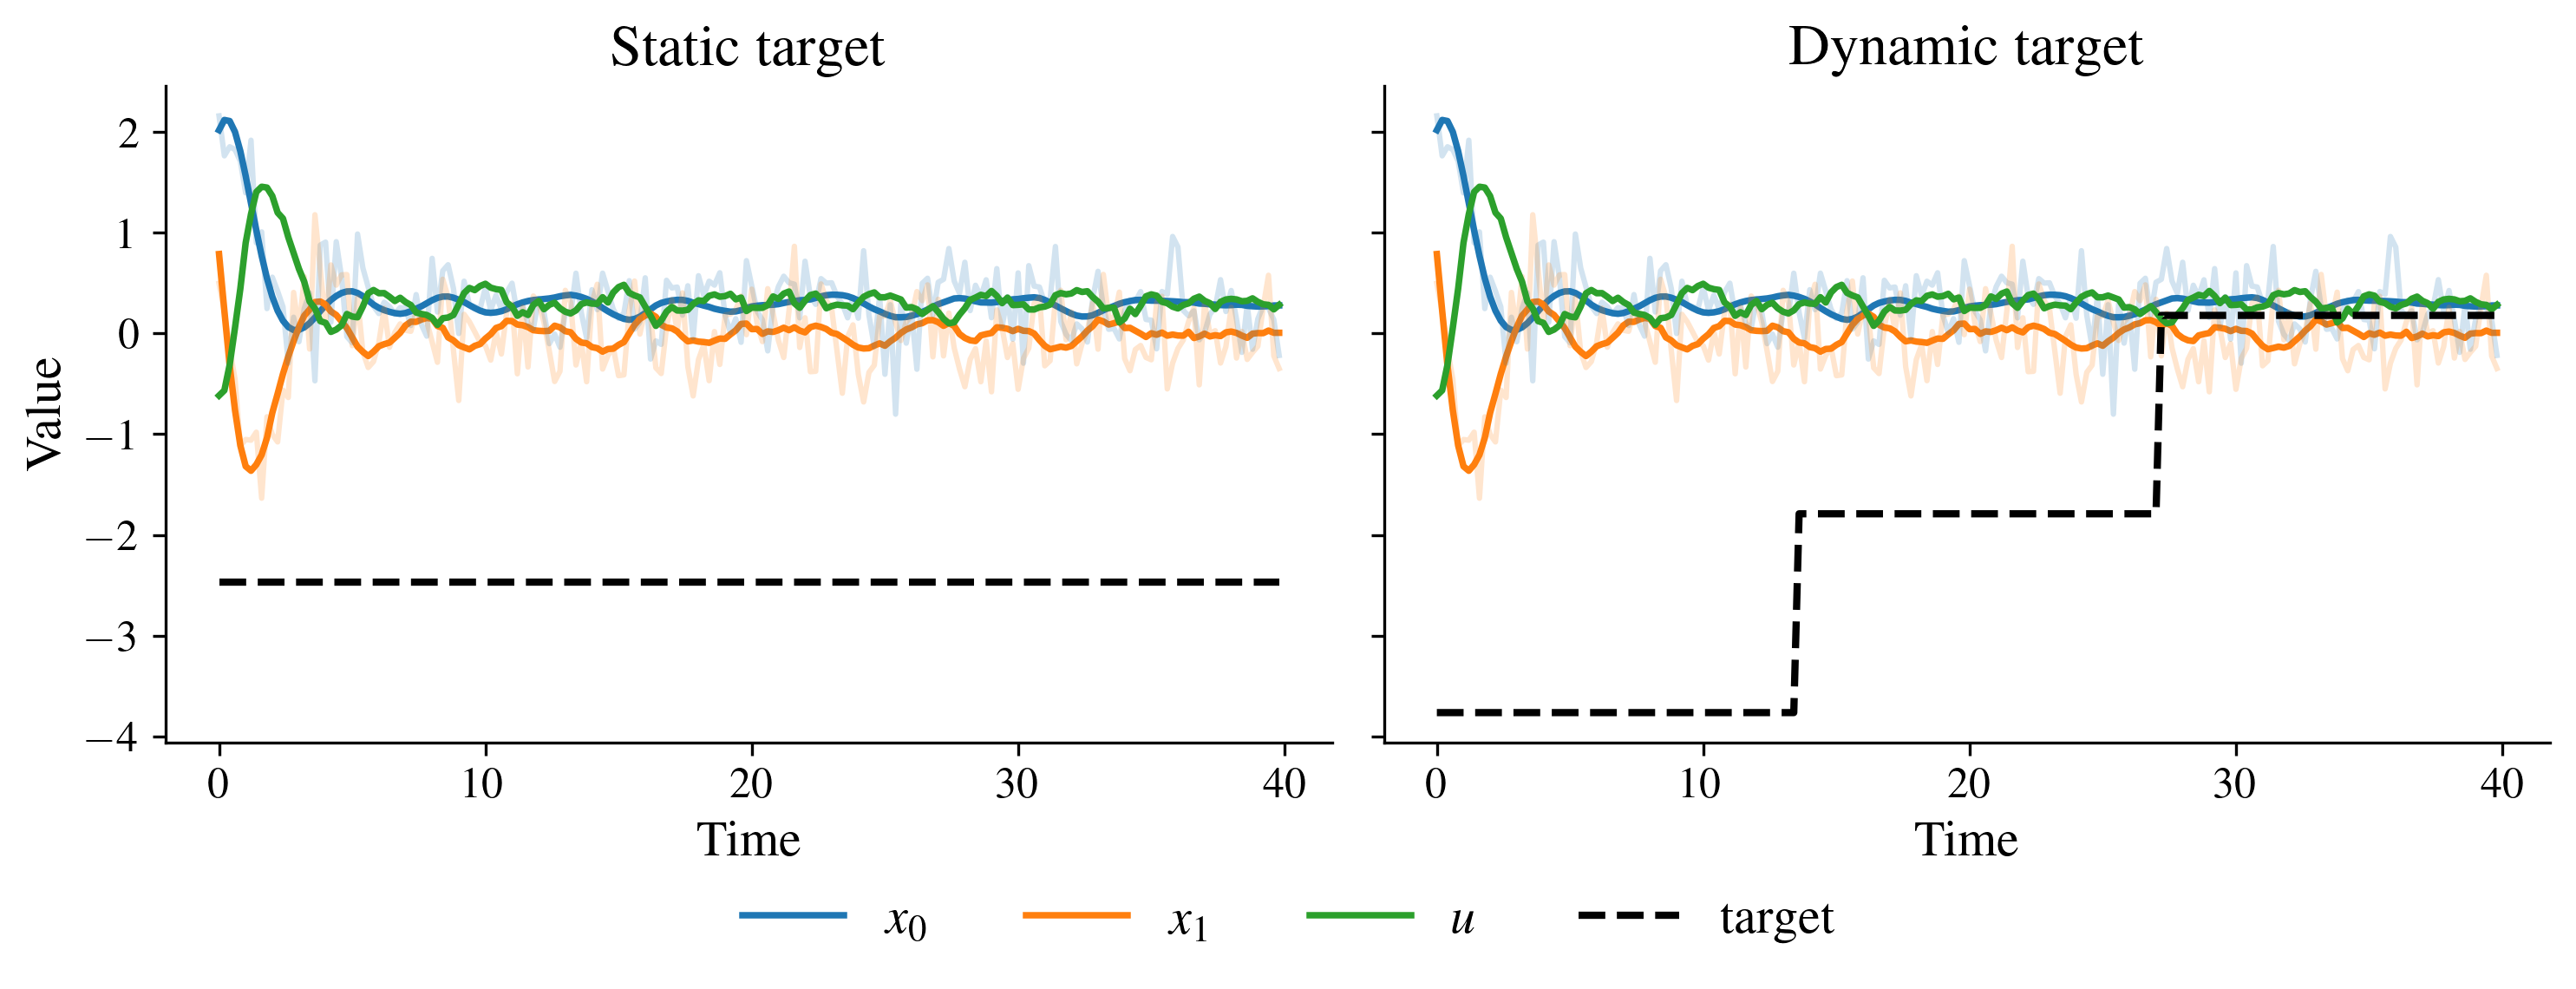

In [16]:
plot_trajectories(model, strategy, fitness_fn, learn_condition, test_data_static, test_data_dynamic)